In [256]:
import re
import torch
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import math


In [257]:
def read_bird_names(fname):
    names = []
    with open(fname, 'r') as fp:
        next(fp)
        for line in fp:
            if ",Aves," in line:
                toks = line.split(',')
                try:
                    name = toks[17].lower()
                    #remove any non a-z, apostrophe or space
                    name = re.sub(r'[^a-z\s]', '', name)
                    name = re.sub(r'\s+', '_', name)
                    name = name.strip()
                    if len(name) > 3:
                        names.append(name)
                except:
                    pass
    return sorted(list(set(names)))
words = read_bird_names("/Users/satyajitgupte/code/birds/taxa_english.csv")

In [258]:
words[:5]

['abbotts_babbler',
 'abbotts_boobies',
 'abbotts_booby',
 'abbotts_lesser_sulphurcrested_cockatoo',
 'abbotts_starling']

In [259]:
len(words)

27045

In [260]:
chars = sorted(list(set(''.join(words))))
# +1 for .
sz = len(chars) + 1

In [261]:
chars
len(chars)

27

In [262]:
itos = {i+1:s for i,s in enumerate(chars)}
itos[0] = '.'
stoi = {s:i for i,s in itos.items()}

In [263]:
stoi

{'_': 1,
 'a': 2,
 'b': 3,
 'c': 4,
 'd': 5,
 'e': 6,
 'f': 7,
 'g': 8,
 'h': 9,
 'i': 10,
 'j': 11,
 'k': 12,
 'l': 13,
 'm': 14,
 'n': 15,
 'o': 16,
 'p': 17,
 'q': 18,
 'r': 19,
 's': 20,
 't': 21,
 'u': 22,
 'v': 23,
 'w': 24,
 'x': 25,
 'y': 26,
 'z': 27,
 '.': 0}

In [264]:
N = torch.zeros(sz, sz, dtype=torch.int64)

In [265]:
for word in words:
    chars = '.' + word + '.'
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1][ix2] += 1

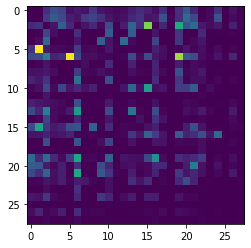

In [266]:
plt.imshow(N)

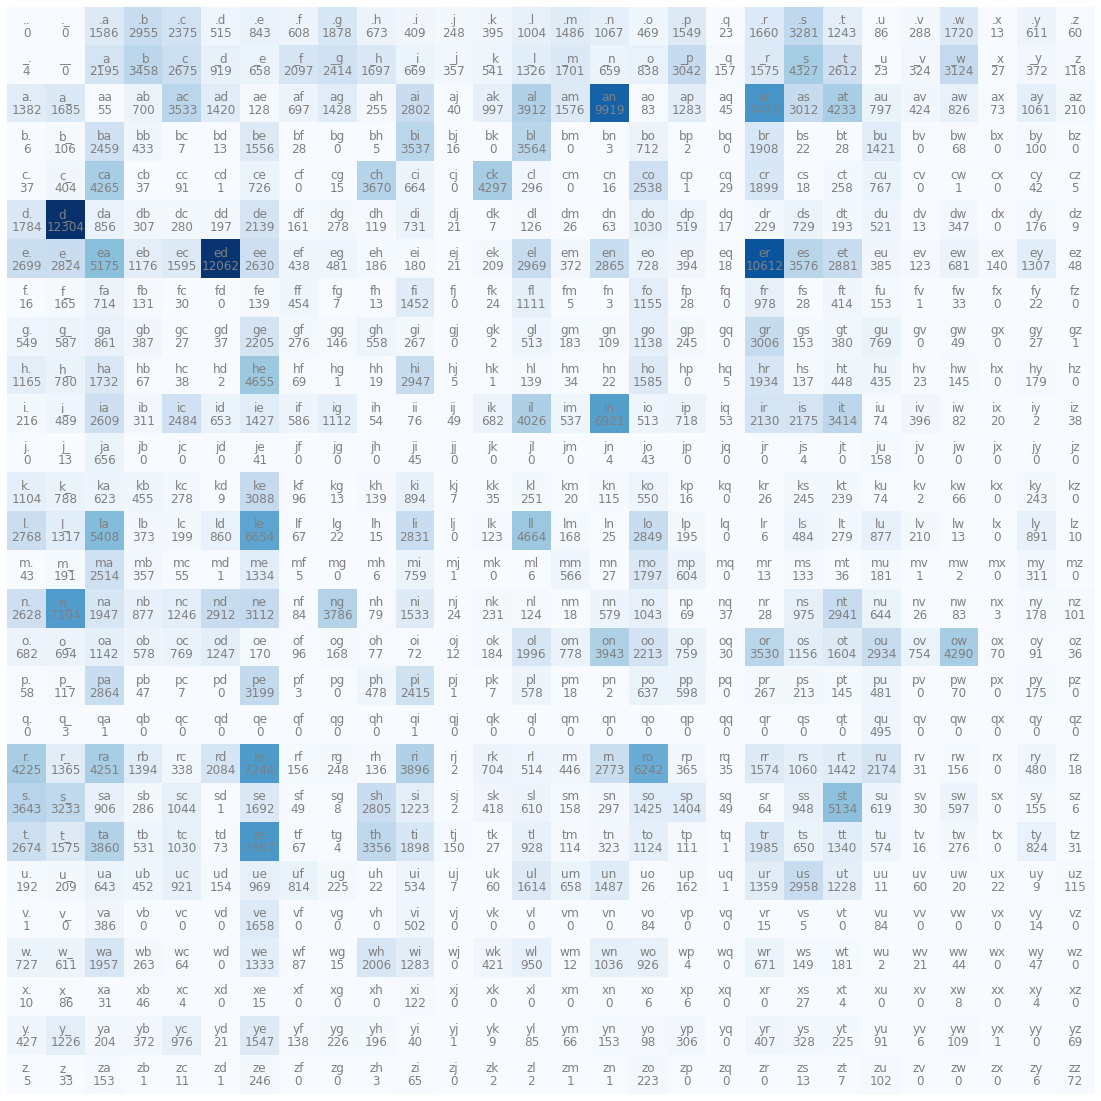

In [267]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,20))
plt.imshow(N, cmap='Blues')
plt.rcParams.update({'font.size': 12})
for i in range(sz):
    for j in range(sz):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [268]:
# +1 for smoothing
N = (N+1).float()
# normalize counts by the row sum
P = N/N.sum(dim=1, keepdim=True)

In [269]:
g = torch.Generator().manual_seed(7)

# sample from multinomial distribution
ix = torch.multinomial(P[0], num_samples=1, replacement=True, generator=g).item()
itos[ix]

'o'

In [271]:
# sample a few words

for _ in range(5):
    ixs = []
    ix = 0
    while True:
        ix = torch.multinomial(P[ix], num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
            break
        ixs.append(ix)
    print(''.join(itos[ix] for ix in ixs))
        

mec_ckillemarm_gfarwhmace_hesw
n_d_lacomoees_curnithemyotir
won
gis_tl_eacagfldbilo
winrino


### calculate negative log likihood

In [272]:
nll = 0
n = 0
for word in words:
    chs = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        p = P[ix1][ix2].item()
        nll += -math.log(p)
        n += 1
print(f"nll={nll}, avg nll={nll/n}")
        
    

nll=1422496.644222023, avg nll=2.5169804024029


In [273]:
# create training dataset 
xs = []
ys = []

for word in words:
    chs = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [274]:
xs

tensor([ 0,  2,  3,  ..., 21, 10, 20])

In [275]:
ys
len(ys)

565160

In [276]:
import torch.nn.functional as F

In [277]:
# one hot encoding
xenc = F.one_hot(xs, num_classes=sz).float()

In [278]:
xenc.shape

torch.Size([565160, 28])

In [279]:
W = torch.randn((sz, sz), requires_grad=True)

In [280]:
logits = xenc @ W
counts = logits.exp()
probs = counts/counts.sum(1, keepdim=True)

In [281]:
probs.shape

torch.Size([565160, 28])

In [282]:

W = torch.randn((sz, sz), requires_grad=True)

In [284]:

losses = []
for _ in range(200):
    x_enc = F.one_hot(xs, num_classes=sz).float()
    
    # forward pass
    # interpre the values in xenc @ W as logits
    logits = x_enc @ W
    counts = logits.exp()
    probs = counts/counts.sum(dim=1, keepdim=True)
    
    loss = -probs[np.arange(len(xs)), ys].log().mean() #+ 0.01*(W**2).mean()
    
    # backward
    W.grad = None
    loss.backward()
    
    # update
    W.data = W.data + -50*W.grad
    losses.append(loss.item())
    print(_, loss.item())
    

0 2.525697946548462
1 2.5256481170654297
2 2.5255990028381348
3 2.525550127029419
4 2.5255017280578613
5 2.525454044342041
6 2.5254065990448
7 2.525359869003296
8 2.52531361579895
9 2.5252678394317627
10 2.5252225399017334
11 2.525177478790283
12 2.5251331329345703
13 2.5250890254974365
14 2.52504563331604
15 2.5250022411346436
16 2.5249595642089844
17 2.5249173641204834
18 2.5248754024505615
19 2.524833917617798
20 2.5247929096221924
21 2.524752378463745
22 2.524712085723877
23 2.524672269821167
24 2.524632692337036
25 2.5245935916900635
26 2.524554491043091
27 2.5245161056518555
28 2.5244781970977783
29 2.5244405269622803
30 2.5244035720825195
31 2.5243663787841797
32 2.524329662322998
33 2.5242936611175537
34 2.524257183074951
35 2.524221897125244
36 2.524186611175537
37 2.524151563644409
38 2.5241167545318604
39 2.524082660675049
40 2.5240485668182373
41 2.524014711380005
42 2.5239813327789307
43 2.5239479541778564
44 2.5239148139953613
45 2.5238823890686035
46 2.523850202560425
47

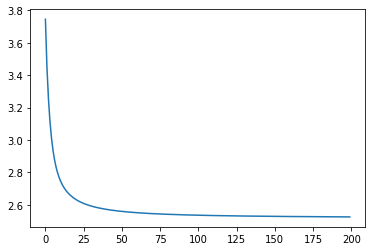

In [251]:
plt.plot(losses)

In [252]:
losses[-1]
#g = torch.Generator().manual_seed(7)

2.5258231163024902

In [235]:
x_enc = F.one_hot(torch.tensor([0]), num_classes=sz).float()
logits = x_enc @ W # 1,28 X 28,28

In [236]:
counts = logits.exp()
probs = counts/counts.sum(dim=1, keepdim = True)

In [237]:
probs.shape

torch.Size([1, 28])

In [238]:
ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()

In [239]:
ix

4

In [285]:
g = torch.Generator().manual_seed(7)
for _ in range(5):
    ix = 0
    ixs = []
    while True:
        x_enc = F.one_hot(torch.tensor([ix]), num_classes=sz).float()
        # forward pass
        # interpre the values in xenc @ W as logits
        logits = x_enc @ W
        counts = logits.exp()
        probs = counts/counts.sum(dim=1, keepdim=True)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
            break
        ixs.append(ix)
    print(''.join(itos[ix] for ix in ixs))


ous
soncre
ba
ttelusedelik
id_n_pisppia_ullatwndrantho


### extend to n-gram

In [326]:
def create_training_set(n):
    # create training dataset 
    xs = []
    ys = []
    for word in words:
        chs = ['.']*n + list(word) + ['.']*n
        ixs = []
        for i in range(len(chs)-n):
            block = chs[i:i+n]
            ixs = [stoi[c] for c in block]
            y = stoi[chs[i+n]] 
            xs.append(ixs)
            ys.append(y)
    return torch.tensor(xs), torch.tensor(ys)
            
        

In [374]:
n = 4
xs, ys = create_training_set(n)

In [375]:
W = torch.randn((sz*n, sz), requires_grad=True)

In [376]:
W.shape

torch.Size([112, 28])

In [377]:
losses = []
for _ in range(1000):
    x_enc = F.one_hot(xs, num_classes=sz).float()
    
    # forward pass
    # interpre the values in xenc @ W as logits
    logits = x_enc.view(-1, sz*n) @ W
    counts = logits.exp()
    probs = counts/counts.sum(dim=1, keepdim=True)
    
    loss = -probs[np.arange(len(xs)), ys].log().mean() + 0.01*(W**2).mean()
    
    # backward
    W.grad = None
    loss.backward()
    
    # update
    W.data = W.data + -50*W.grad
    losses.append(loss.item())
    print(_, loss.item())
    

0 5.082244873046875
1 4.16111946105957
2 3.5602283477783203
3 3.2152512073516846
4 2.9411258697509766
5 2.7887043952941895
6 2.680372476577759
7 2.5932750701904297
8 2.521756410598755
9 2.4621193408966064
10 2.4118547439575195
11 2.3690671920776367
12 2.3323302268981934
13 2.3005313873291016
14 2.2728030681610107
15 2.248450517654419
16 2.2269184589385986
17 2.207758903503418
18 2.1906073093414307
19 2.175168752670288
20 2.1612014770507812
21 2.1485061645507812
22 2.1369194984436035
23 2.126303195953369
24 2.1165425777435303
25 2.107541084289551
26 2.099215269088745
27 2.0914950370788574
28 2.0843183994293213
29 2.077632188796997
30 2.071390151977539
31 2.065551519393921
32 2.060079336166382
33 2.0549421310424805
34 2.050111770629883
35 2.045562267303467
36 2.0412709712982178
37 2.037217855453491
38 2.033383846282959
39 2.0297534465789795
40 2.026310682296753
41 2.0230424404144287
42 2.0199363231658936
43 2.016981363296509
44 2.014166831970215
45 2.011484384536743
46 2.0089242458343506

KeyboardInterrupt: 

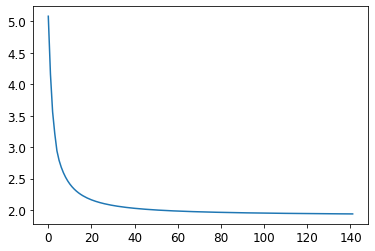

In [378]:
plt.plot(losses)

In [379]:
g = torch.Generator().manual_seed(7)

In [380]:

n


oustsoncres_finte_sted_wriged_nuins
pia_umerownd_gnthis
bued_jaiadd_inthias
mec_chilled_smooparwhiace_flew
ned_lackooeds_curniterm
oripet_heris_flyeacazen
bill
wvir
bolleweswen_jaru
sortain
rowe
piclow_wested_bluthires
yenypetill
powtyelicatt
calen_gor
